# 6-3. 프로젝트: 배경전환 크로마키

### Step 1. 화분 배경 교체하기

In [3]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
import pixellib
from matplotlib import pyplot as plt

# 원본 이미지 불러오기
img_path_03 = os.getenv('HOME')+'/aiffel/human_segmentation/images/pottedplant_01.jpg'  
img_orig_03 = cv2.imread(img_path_01)

# 새 배경 이미지 불러오기 (사이즈는 원본과 동일하게 조정해야 함)
bg_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/Beach_Sand.jpg'  # 원하는 배경 이미지
img_bg = cv2.imread(bg_path)
img_bg = cv2.resize(img_bg, (img_orig_03.shape[1], img_orig_03.shape[0]))


In [2]:
# DeepLabV3 모델 다운로드 및 불러오기
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

if not os.path.exists(model_file):
    urllib.request.urlretrieve(model_url, model_file)

# 모델 로드 및 분할 수행
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)
segvalues, output = model.segmentAsPascalvoc(img_path_01)


(456, 418, 3)


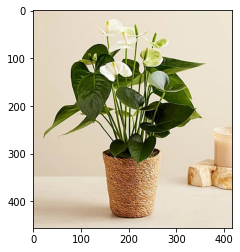

In [4]:
print(img_orig_03.shape)

plt.imshow(cv2.cvtColor(img_orig_03, cv2.COLOR_BGR2RGB))
plt.show()

(456, 418, 3)


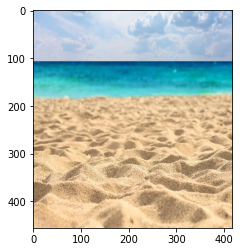

In [5]:
print(img_bg.shape)

plt.imshow(cv2.cvtColor(img_bg, cv2.COLOR_BGR2RGB))
plt.show()

In [6]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

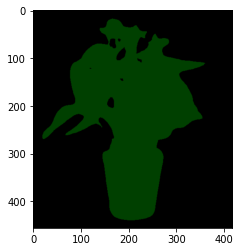

In [7]:
#segmentAsPascalvoc() 함수 를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 output을 matplotlib을 이용해 출력
plt.imshow(output)
plt.show()

In [8]:
segvalues # segmentAsPascalvoc() 함수를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 배열값을 출력

{'class_ids': array([ 0, 16]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [9]:
#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
pottedplant


In [10]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!

#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [11]:
colormap[16] #컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)

array([ 0, 64,  0])

In [12]:
seg_color = (0,64,0) # 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있어서

(456, 418)


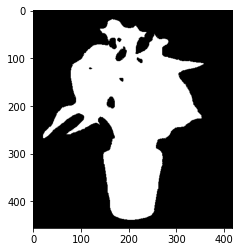

In [13]:
# 사람만 추출하는 마스크 생성

seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

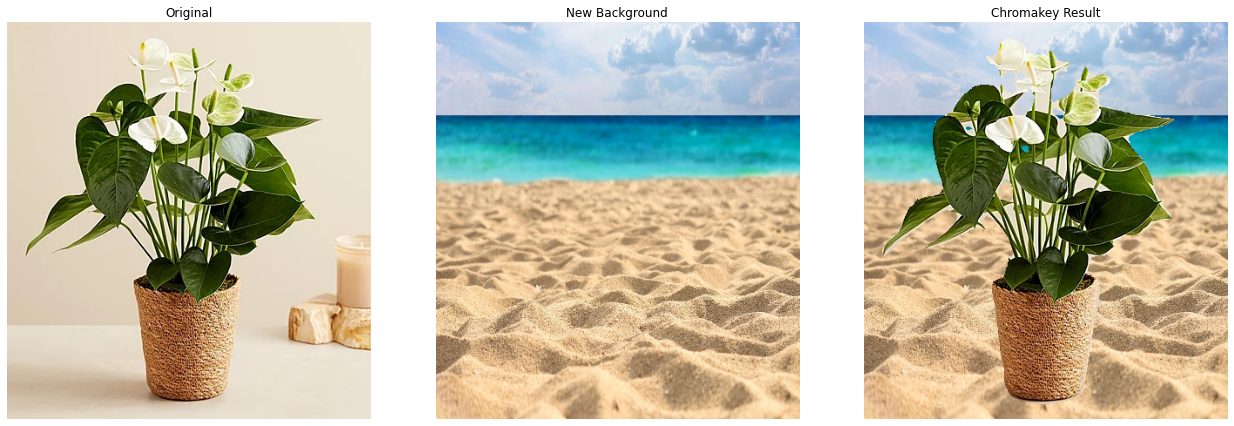

In [14]:



# 마스크 형태 조정
mask = seg_map.astype(np.uint8) * 255
mask_bgr = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
inv_mask_bgr = cv2.bitwise_not(mask_bgr)

# 화분 영역만 추출
plant_only = cv2.bitwise_and(img_orig_03, mask_bgr)

# 배경 영역만 추출
bg_only = cv2.bitwise_and(img_bg, inv_mask_bgr)

# 두 개 합치기
img_chroma = cv2.add(plant_only, bg_only)

# 결과 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(cv2.cvtColor(img_orig_01, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(img_bg, cv2.COLOR_BGR2RGB))
axes[1].set_title('New Background')
axes[1].axis('off')

axes[2].imshow(cv2.cvtColor(img_chroma, cv2.COLOR_BGR2RGB))
axes[2].set_title('Chromakey Result')
axes[2].axis('off')

plt.tight_layout()
plt.show()


### Step 2. 사진에서 문제점 찾기

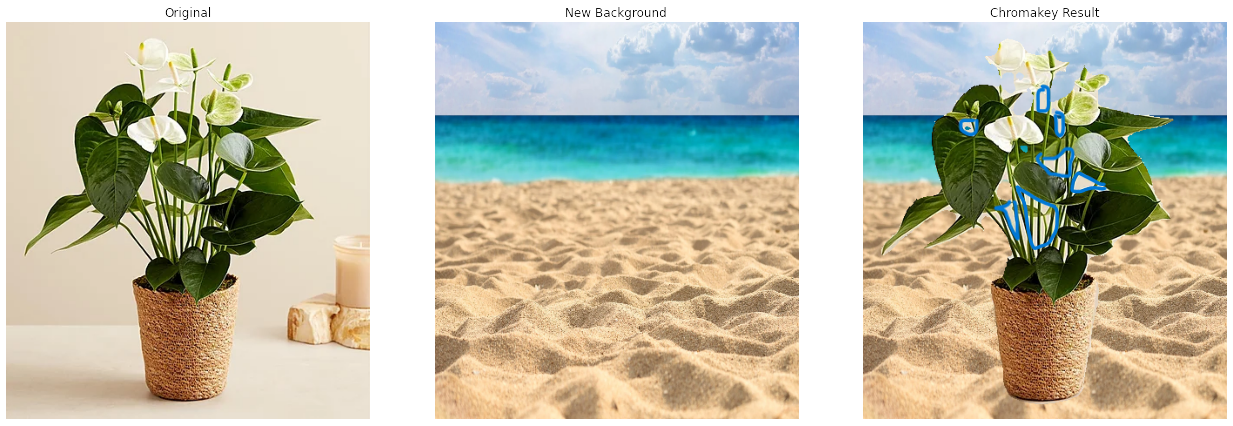
줄기와 줄기 사이의 배경을 배경으로 인식하지 못하고 있음